# Training the model and evaluating 2

### Imports

In [1]:
import sys
import os
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


current_dir = os.getcwd()

# Define the project root relative to the current working directory
project_root = os.path.abspath(os.path.join(current_dir, "../"))  # Adjust this based on your folder structure

# Add project_root to sys.path
sys.path.append(project_root)

from src.modeling.oversample import OversamplingContext, SMOTEStrategy
from src.modeling.randomforest_model import ModelContext, RandomForestModel
from src.modeling.xgboost_model import ModelContext, XGBoostModel
from src.modeling.isoforest_model import ModelContext, IsolationForestModel
from src.modeling.hyperparameter_tune import HyperparameterTuningContext, XGBoostHyperparameterTuning
from src.modeling.evaluation import ModelEvaluationContext, StandardEvaluation, AnomalyDetectionEvaluation
from src.modeling.explainability import ExplainabilityContext, SHAPExplainability, IsolationForestFeatureImportance, PermutationFeatureImportance, RandomForestFeatureImportance

c:\Users\Geeneth\Desktop\Code\Machine Learning\PycharmProjects\Fraud Detection\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Loading the data
data = pd.read_csv('../data/processed/processed_data.csv')
data

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,transaction_count,balance_change,amount_balance_ratio
0,1,4,0.000003,181.00,0.00,0.00,0.00,1,0,144,-1.000000,1.430887e-08
1,1,1,0.000003,181.00,0.00,21182.00,0.00,1,0,144,-1.000000,1.430887e-08
2,1,4,0.000040,2806.00,0.00,0.00,0.00,1,0,144,-1.000000,1.430887e-08
3,1,1,0.000040,2806.00,0.00,26202.00,0.00,1,0,144,-1.000000,1.430887e-08
4,1,4,0.000288,20128.00,0.00,0.00,0.00,1,0,144,-1.000000,1.430887e-08
...,...,...,...,...,...,...,...,...,...,...,...,...
299995,304,1,0.001507,3049.00,0.00,142456.32,247741.84,0,0,1186,-1.000000,4.941019e-07
299996,45,3,0.000249,0.00,0.00,0.00,0.00,0,0,838,0.000000,2.489282e+01
299997,14,0,0.002603,5466706.55,5648636.77,393631.67,211701.44,0,0,2016,0.033280,4.761945e-10
299998,130,0,0.000983,2704007.61,2772675.85,1251847.48,1183179.23,0,0,1550,0.025395,3.633736e-10


### Spliting the dataset

In [3]:
X = data.drop("isFraud", axis=1)  # Features
y = data["isFraud"]  # Target

# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Training Set:", X_train.shape)
print("Test Set:", X_test.shape)

Training Set: (240000, 11)
Test Set: (60000, 11)


In [4]:
X.shape

(300000, 11)

In [5]:
sum(data["isFraud"] == 1)

8213

In [6]:
sum(data["isFraud"] == 0)

291787

In [7]:
X_train.shape

(240000, 11)

In [8]:
y_train.shape

(240000,)

### SMOTE Oversampling

In [9]:
# Apply SMOTE Oversampling
oversampler = OversamplingContext(SMOTEStrategy(sampling_strategy=0.2))

In [10]:
X_train_resampled, y_train_resampled = oversampler.apply(X_train, y_train)

# Display class distribution after resampling
print(y_train_resampled.value_counts())

isFraud
0    233430
1     46686
Name: count, dtype: int64


In [11]:
sum(y_train_resampled == 1)

46686

In [12]:
sum(y_train_resampled == 0)

233430

# Model training

### Random Forest

In [13]:
# Initialize and Train Model
model_context = ModelContext(RandomForestModel(n_estimators=100, random_state=42))
model_context.train_model(X_train_resampled, y_train_resampled)

In [14]:
# Make Predictions
y_pred = model_context.make_predictions(X_test)

# Evaluate Model
print(model_context.evaluate_model(y_test, y_pred))

Model saved at ../model/random_forest.pkl
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58357
           1       1.00      1.00      1.00      1643

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000



### xgboost

In [15]:
# Initialize and Train Model
model_context = ModelContext(XGBoostModel(use_label_encoder=False, eval_metric="logloss"))
model_context.train_model(X_train_resampled, y_train_resampled)

c:\Users\Geeneth\Desktop\Code\Machine Learning\PycharmProjects\Fraud Detection\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [07:27:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [16]:
# Make Predictions
y_pred_xgb = model_context.make_predictions(X_test)

# Evaluate Model
print(model_context.evaluate_model(y_test, y_pred_xgb))

Model saved at ../model/xgboost_model.pkl
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58357
           1       0.98      0.99      0.98      1643

    accuracy                           1.00     60000
   macro avg       0.99      1.00      0.99     60000
weighted avg       1.00      1.00      1.00     60000



### IsolationForest

In [17]:
# Initialize and Train Model
model_context = ModelContext(IsolationForestModel(n_estimators=100, contamination=0.01, random_state=42))
model_context.train_model(X_train_resampled)

In [18]:
# Make Predictions
y_pred_iso = model_context.make_predictions(X_test)

# Evaluate Model
print("Isolation Forest Classification Report:")
print(model_context.evaluate_model(y_test, y_pred_iso))

Isolation Forest Classification Report:
Model saved at ../model/isolation_forest.pkl
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     58357
           1       0.17      0.04      0.06      1643

    accuracy                           0.97     60000
   macro avg       0.57      0.52      0.52     60000
weighted avg       0.95      0.97      0.96     60000



## Hyperparameter tuning (XGBoost)

In [19]:
# Initialize and Perform Hyperparameter Tuning
tuning_context = HyperparameterTuningContext(XGBoostHyperparameterTuning())

In [20]:
best_params = tuning_context.perform_tuning(X_train_resampled, y_train_resampled)

print("Best Hyperparameters for XGBoost:", best_params)

Best Hyperparameters for XGBoost: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 300}


## Evaluation metrics 

### Loading all the models

In [21]:
rf_model = joblib.load('../model/random_forest.pkl')
xgb_model = joblib.load('../model/xgboost_model.pkl')
iso_forest = joblib.load('../model/isolation_forest.pkl')

Random Forest:
Precision: 0.9994
Recall: 0.9957
F1 Score: 0.9976


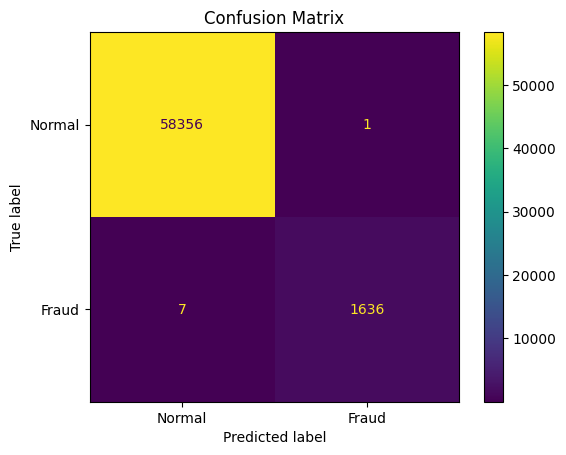

In [22]:
# Evaluate Random Forest
print("Random Forest:")
rf_evaluator = ModelEvaluationContext(StandardEvaluation())
rf_evaluator.evaluate_model(rf_model, X_test, y_test)


XGBoost:
Precision: 0.9784
Recall: 0.9909
F1 Score: 0.9846


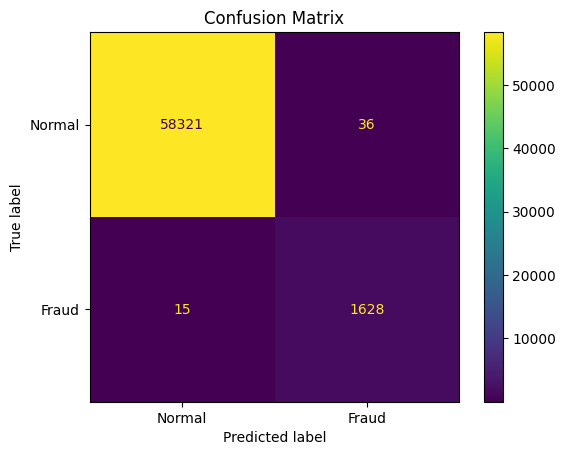

In [23]:
# Evaluate XGBoost
print("\nXGBoost:")
xgb_evaluator = ModelEvaluationContext(StandardEvaluation())
xgb_evaluator.evaluate_model(xgb_model, X_test, y_test)


Isolation Forest:
Precision: 0.1713
Recall: 0.0371
F1 Score: 0.0610


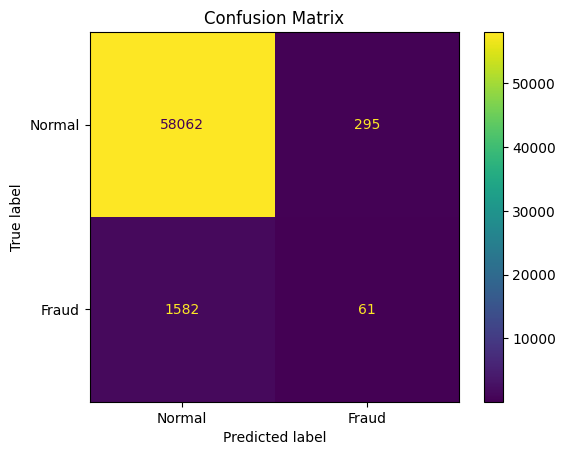

In [24]:
# Evaluate Isolation Forest (Anomaly Detection)
print("\nIsolation Forest:")
iso_evaluator = ModelEvaluationContext(AnomalyDetectionEvaluation())
iso_evaluator.evaluate_model(iso_forest, X_test, y_test)

# Explainability

SHAP Explainability for XGBoost:
Generating SHAP explanations...


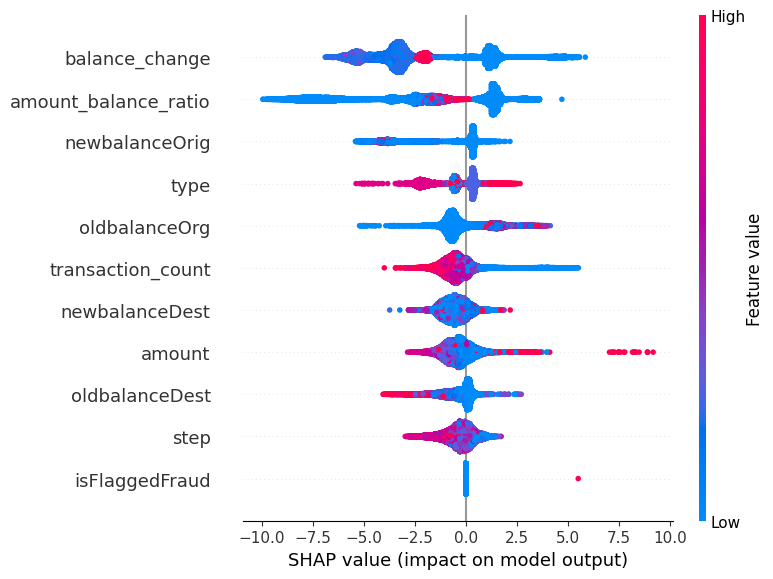

In [25]:
# Explain XGBoost Model with SHAP
print("SHAP Explainability for XGBoost:")
shap_explainer = ExplainabilityContext(SHAPExplainability())
shap_explainer.explain_model(xgb_model, X_test, y_test)


Feature Importance - Isolation Forest:
Computing Feature Importance for Isolation Forest...


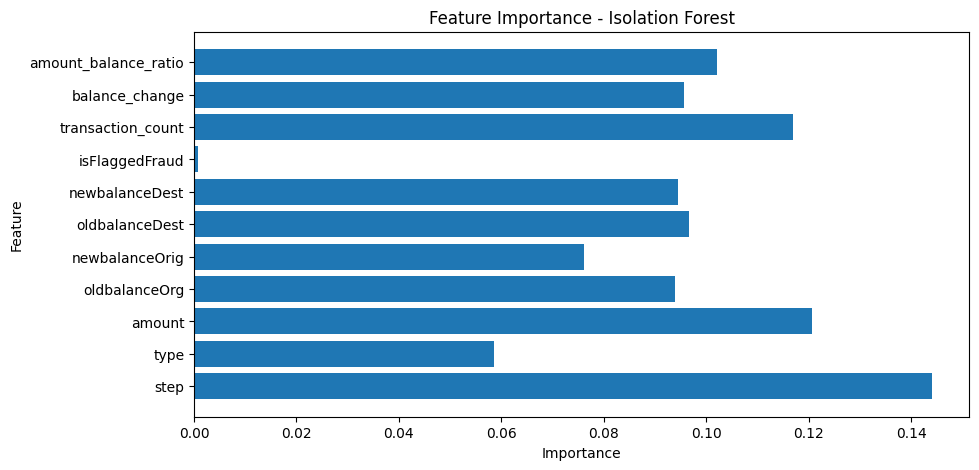

In [26]:
# Explain Isolation Forest Feature Importance
print("\nFeature Importance - Isolation Forest:")
iso_explainer = ExplainabilityContext(IsolationForestFeatureImportance())
iso_explainer.explain_model(iso_forest, X_test, y_test)


Permutation Feature Importance - Isolation Forest:
Computing Permutation Feature Importance...


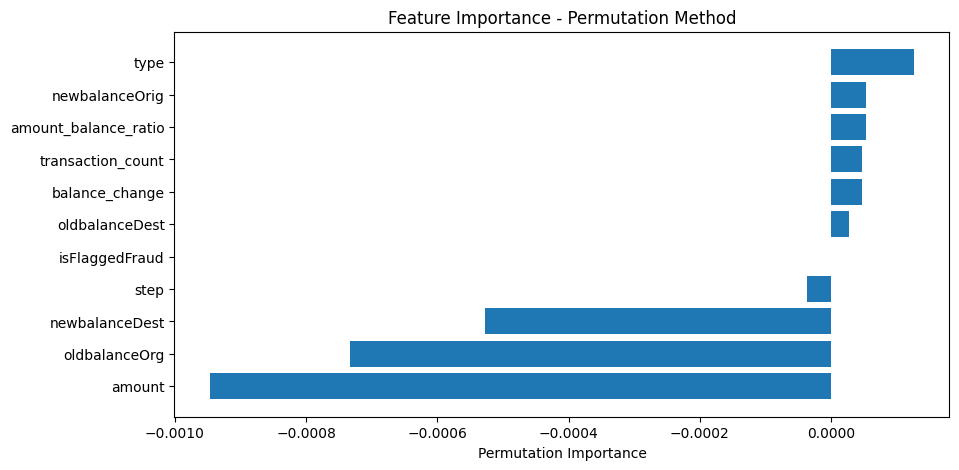

In [27]:
# Explain Isolation Forest using Permutation Feature Importance
print("\nPermutation Feature Importance - Isolation Forest:")
perm_explainer = ExplainabilityContext(PermutationFeatureImportance())
perm_explainer.explain_model(iso_forest, X_test, y_test)


Feature Importance - Random Forest:
Computing Feature Importance for Random Forest...


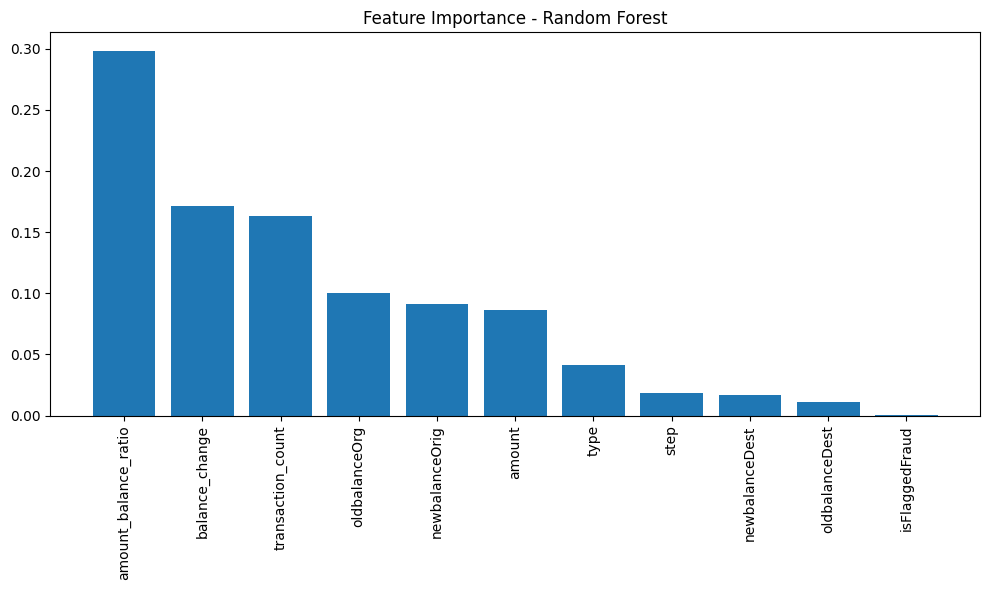

In [28]:
# Explain Random Forest Feature Importance
print("\nFeature Importance - Random Forest:")
rf_explainer = ExplainabilityContext(RandomForestFeatureImportance())
rf_explainer.explain_model(rf_model, X_test, y_test)